## Load Libraries

In [1]:
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import skimage.measure
import matplotlib.pyplot as plt
from glob import glob
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from skimage.feature import greycomatrix, greycoprops
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, KFold
%matplotlib inline

## Load Dataset

In [2]:
df = pd.read_csv("Image_Dataset_Color_Texture_Shape_Features.csv")

## Display Image

In [3]:
def display(img):
    plt.imshow (img, interpolation = 'nearest')
    _ = plt.axis(False)
    print("Image Shape: ", img.shape)

## Seperate the target and independant variables

In [4]:
df_X = df.iloc[:, 0:-1]
df_Y = df.iloc[:, -1]

In [5]:
df_X.shape

(2940, 521)

## Principle Component Analysis

In [6]:
# from sklearn.decomposition import PCA
# pca=PCA(n_components=10)
# df_X=pca.fit_transform(df_X)

## Stratified K-Fold Validation

In [7]:
# kf = KFold(n_splits=4)
# kf.get_n_splits(df_X)

# for train_index, test_index in kf.split(df_X):
#     X_train, X_test = df_X.iloc[train_index], df_X.iloc[test_index]
#     y_train, y_test = df_Y.iloc[train_index], df_Y.iloc[test_index]
# print(len(X_train), len(X_test))

## Train Test Split Model

In [8]:
#Split the dataset
X_train, X_test, y_train, y_test = train_test_split(df_X, df_Y, test_size=0.2, random_state=0)

## Train Random Forest Model

In [9]:
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train,y_train)

RandomForestClassifier()

In [10]:
y_pred = model.predict(X_test)

## Cross Validation Score

In [11]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(model, df_X, df_Y, cv=5)
print(score)

[1. 1. 1. 1. 1.]


## Accuracy of Model

In [12]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred, normalize=False))
print(accuracy_score(y_test, y_pred))

588
1.0


In [13]:
# count=0 
# total = df_X.shape[0]
# for i in range(total):
#     check = model.predict([df_X.iloc[i]])
#     if check[0] == df_Y.iloc[i] :
#         count += 1
# print(count)
# print("Accuracy is ", count/total)

## Classification Report

In [14]:
pd.DataFrame(classification_report(y_test, y_pred, output_dict = True)).T

,precision,recall,f1-score,support
Apple,1.0,1.0,1.0,98.0
Grape,1.0,1.0,1.0,103.0
Lemon,1.0,1.0,1.0,108.0
Limes,1.0,1.0,1.0,115.0
Lychee,1.0,1.0,1.0,85.0
Pear,1.0,1.0,1.0,79.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,588.0
weighted avg,1.0,1.0,1.0,588.0


## Confusion matrix

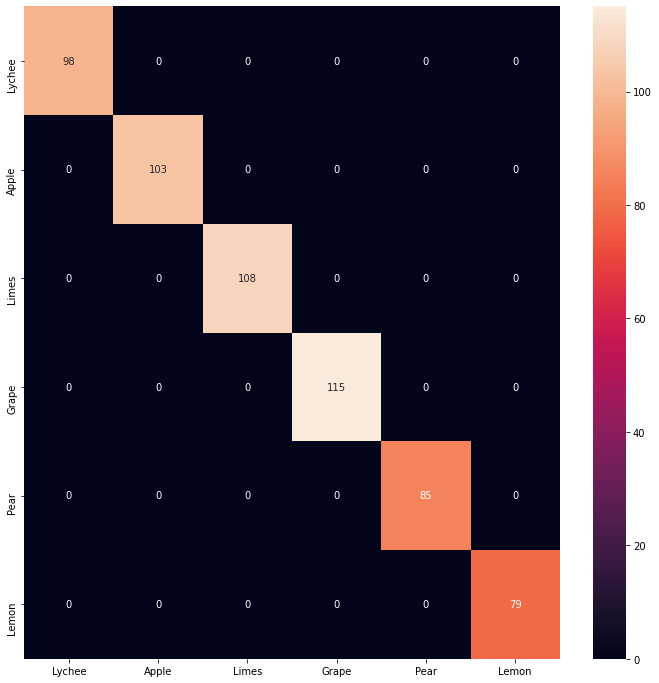

In [15]:
from sklearn.metrics import confusion_matrix
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred), index = df_Y.unique(), columns = df_Y.unique())
fig = plt.figure(figsize=(12,12))
sns.heatmap(confusion_matrix_df,annot=True, fmt='g')
plt.show()

## Train Support Vector Machine

In [16]:
# from sklearn import svm
# model = svm.SVC(decision_function_shape='ovo')
# model.fit(X_train,y_train)

In [17]:
# y_pred = model.predict(X_test)

In [18]:
# count=0 
# total = df_X.shape[0]
# for i in range(total):
#     check=model.predict([df_X.iloc[i]])
#     if check[0] == df_Y.iloc[i] :
#         count += 1
# print(count)
# print("Accuracy is ", count/total)

In [19]:
# pd.DataFrame(classification_report(y_test, y_pred, output_dict = True)).T

In [20]:
# from sklearn.metrics import confusion_matrix
# confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred), index = df_Y.unique(), columns = df_Y.unique())
# fig = plt.figure(figsize=(12,12))
# sns.heatmap(confusion_matrix_df,annot=True, fmt='g')
# plt.show()

In [21]:
# print(model.predict([df_X.iloc[6]])[0], df_Y.iloc[6])

## Test Image

### Remove White Background (Threshold)

In [22]:
def remove_background(img, threshold):
    """
    This method removes background from your image
    
    :param img: cv2 image
    :type img: np.array
    :param threshold: threshold value for cv2.threshold
    :type threshold: float
    :return: RGBA image
    :rtype: np.ndarray
    """
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, threshed = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY_INV)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    morphed = cv2.morphologyEx(threshed, cv2.MORPH_CLOSE, kernel)
    
    cnts = cv2.findContours(morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
    cnt = sorted(cnts, key=cv2.contourArea)[-1]

    mask = cv2.drawContours(threshed, cnt, 0, (0, 255, 0), 0)
    masked_data = cv2.bitwise_and(img, img, mask=mask)

    x, y, w, h = cv2.boundingRect(cnt)
    dst = masked_data[y: y + h, x: x + w]

    dst_gray = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)
    _, alpha = cv2.threshold(dst_gray, 0, 255, cv2.THRESH_BINARY)
    b, g, r = cv2.split(dst)

    rgba = [r, g, b, alpha]
    dst = cv2.merge(rgba, 4)
    
    dst = cv2.cvtColor(dst, cv2.COLOR_BGRA2RGB)

    return dst

### Conversion Function

#### Convert Val To RGB

In [23]:
# def convert_val_to_rgb(x):
#     if x >= 0 and x < 64:
#         return "00"
#     elif x >= 64 and x < 128:
#         return "55"
#     elif x >= 128 and x < 192:
#         return "AA"
#     else:
#         return "FF"

In [24]:
# def convert_val_to_rgb(x):
#     if x >= 0 and x < 42.5:
#         return "00"
#     elif x >= 42.5 and x < 85:
#         return "33"
#     elif x >= 85 and x < 127.5:
#         return "66"
#     elif x >= 127.5 and x < 170:
#         return "99"
#     elif x >= 170 and x < 212.5:
#         return "CC"
#     else:
#         return "FF" 

In [25]:
def convert_val_to_rgb(x):
    if x >= 0 and x < 32:
        return "00"
    elif x >= 32 and x < 64:
        return "24"
    elif x >= 64 and x < 96:
        return "40"
    elif x >= 96 and x < 128:
        return "60"
    elif x >= 128 and x < 160:
        return "80"
    elif x >= 160 and x < 192:
        return "A0"
    elif x >= 192 and x < 224:
        return "C0"
    else:
        return "FF" 

#### Convert Val To Bin

In [26]:
# def convert_val_to_bin(x):
#     if x >= 0 and x < 64:
#         return 0
#     elif x >= 64 and x < 128:
#         return 85
#     elif x >= 128 and x < 192:
#         return 170
#     else:
#         return 255

In [27]:
# def convert_val_to_bin(x):
#     if x >= 0 and x < 42.5:
#         return 42
#     elif x >= 42.5 and x < 85:
#         return 84
#     elif x >= 85 and x < 127.5:
#         return 127
#     elif x >= 127.5 and x < 170:
#         return 169
#     elif x >= 170 and x < 212.5:
#         return 212
#     else:
#         return 255

In [28]:
def convert_val_to_bin(x):
    if x >= 0 and x < 32:
        return 31
    elif x >= 32 and x < 64:
        return 63
    elif x >= 64 and x < 96:
        return 95
    elif x >= 96 and x < 128:
        return 127
    elif x >= 128 and x < 160:
        return 159
    elif x >= 160 and x < 192:
        return 191
    elif x >= 192 and x < 224:
        return 223
    else:
        return 255

### Pipeline Color Features

In [29]:
def pipeline_color(cv_img):
    img_arr = np.array(cv_img)
    img_flatten = img_arr.reshape(1, -1).T
    img_squeeze = np.squeeze(img_flatten)
    img_convert = np.vectorize(convert_val_to_rgb)(img_squeeze)
    img_2d_arr = img_convert.reshape(-1, 3)
    img_list_arr = img_2d_arr.tolist()
    convert_to_str = lambda x:"#"+"".join(list(map(str, x)))
    img_str_arr = [convert_to_str(x) for x in img_list_arr]
    new_arr = np.array(img_str_arr)
    tmp_dict = {a:b for (a,b) in zip(np.unique(new_arr, return_counts=True)[0], np.unique(new_arr, return_counts=True)[1])}
    return tmp_dict

### Pipeline Texture Features

In [30]:
def pipeline_texture(img_gray):
    tmp_dict = {}
    tmp_dict["Mean"] = np.mean(img_gray)
    tmp_dict["Variance"] = np.var(img_gray)
    tmp_dict["Entropy"] = skimage.measure.shannon_entropy(img_gray)
    glcm = greycomatrix(img_gray, [2], [0], 256, symmetric = True, normed = True)
    tmp_dict["Contrast"] = greycoprops(glcm, prop="contrast").item()
    tmp_dict["Homogeneity"] = greycoprops(glcm, prop="homogeneity").item()
    tmp_dict["Correlation"] = greycoprops(glcm, prop="correlation").item()
    tmp_dict["Energy"] = greycoprops(glcm, prop="energy").item()
    return tmp_dict

### Pipeline Shape Features

In [31]:
def pipeline_shape(img_gray):
    # Apply Gaussian Blur to Image
    img_blur = cv2.GaussianBlur(img_gray, (7,7), 1)

    # Canny Edge Detection
    img_canny = cv2.Canny(img_blur, 50, 150)

    # Edge Detector
    kernel = np.ones((5, 5), dtype = np.uint8)
    img_dilate = cv2.dilate(img_canny, kernel, iterations = 1)

    contours, hier = cv2.findContours(img_dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    area, peri = 0, 0
    for cnt in contours:
        area = cv2.contourArea(cnt)
        peri = cv2.arcLength(cnt, True)
    tmp_dict = {}
    tmp_dict["Area"] = area
    tmp_dict["Perimeter"] = peri
    return tmp_dict

### Pipeline Final

In [32]:
def pipeline_final(img_path,alpha = 1.5, beta = 0, threshold = 225, w = 100, h = 100):
    final_dict = {}
    
    cv_img = cv2.imread(img_path)
    
    # Resize Image
    cv_img = cv2.resize(cv_img, (w,h),interpolation = cv2.INTER_AREA)
    
    # Remove White Background
    cv_img = remove_background(cv_img, threshold)
    
    # Convert Image from RGB to BGR
    cv_img = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)
    
    # Darken Image
    cv_img = cv2.convertScaleAbs(cv_img, alpha=0.75, beta=20)
    
    # Get Color Features
    color_feature_dict = pipeline_color(cv_img)
    final_dict.update(color_feature_dict)
    
    # Convert Image to Gray Image
    img_gray = cv2.cvtColor(cv_img, cv2.COLOR_RGB2GRAY)

    # Get Texture Features
    texture_feature_dict = pipeline_texture(img_gray)
    final_dict.update(texture_feature_dict)

    # Get Shape Features
    shape_feature_dict = pipeline_shape(img_gray)
    final_dict.update(shape_feature_dict)
    
    return final_dict

In [33]:
feature_arr = []
# cc = ["00", "55", "AA", "FF"]
# cc = ["00", "33", "66", "99", "CC", "FF"]
cc = ["00", "24", "40", "60", "80", "A0", "C0", "FF"]
for i in cc:
    for j in cc:
        for k in cc:
            feature_arr.append(f"#{i}{j}{k}")
feature_arr += ["Mean", "Variance", "Entropy", "Contrast", "Homogeneity", "Correlation", "Energy","Area", "Perimeter"]

## List All Folders

In [34]:
image_folders = glob('Test_Images/*/')

## List all Files

In [35]:
for folder_path in image_folders:
    folder_name = folder_path.split("\\")[1]
    all_image_in_folder = glob(folder_path + "*.jpg")

## Verify Model Function

In [46]:
def test_model(model, feature_arr, test_folder = "Test_Images"):
    image_folders = glob(f'{test_folder}/*/')
    for folder_path in image_folders:
        final_df = pd.DataFrame(columns = feature_arr)
        fruit_name = folder_path.split("\\")[1]
        all_image_in_folder = glob(folder_path + "*.jpg")
        for img_path in all_image_in_folder:
            final_dict = pipeline_final(img_path)
            final_df = final_df.append(final_dict, ignore_index = True)
        final_df.fillna(0, inplace=True)
        pred_label = model.predict(final_df)
        for (pred_fruit_name, img_path) in zip(pred_label, all_image_in_folder):
            img_name = img_path.split("\\")[-1]
            print(f"Success! {img_name} is {pred_fruit_name}!" if pred_fruit_name == fruit_name else f"Error... {img_name} is not {pred_fruit_name}...")

In [47]:
test_model(model, feature_arr)

Success! apple1.jpg is Apple!
Success! apple2.jpg is Apple!
Success! apple3.jpg is Apple!
Success! apple4.jpg is Apple!
Success! grape1.jpg is Grape!
Success! grape2.jpg is Grape!
Success! grape3.jpg is Grape!
Error... grape4.jpg is not Lemon...
Success! lemon1.jpg is Lemon!
Success! lemon2.jpg is Lemon!
Error... lemon3.jpg is not Limes...
Success! lemon4.jpg is Lemon!
Success! Limes1.jpg is Limes!
Success! Limes2.jpg is Limes!
Success! Limes3.jpg is Limes!
Error... Lychee1.jpg is not Apple...
Success! Lychee2.jpg is Lychee!
Success! Lychee3.jpg is Lychee!
Success! pear1.jpg is Pear!
Error... pear2.jpg is not Lemon...
Success! pear3.jpg is Pear!
